In [1]:
from google.colab import files
uploaded = files.upload()

Saving DataSet.rar to DataSet.rar


In [2]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
!unrar x DataSet.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from DataSet.rar

Creating    DataSet                                                   OK
Creating    DataSet/Data_cloudy                                       OK
Extracting  DataSet/Data_cloudy/train_10021.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10070.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10096.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_101.jpg                              0%  OK 
Extracting  DataSet/Data_cloudy/train_10128.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10177.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10231.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10451.jpg                            0%  OK 
Extracting  D

In [4]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder('/content/DataSet', transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [6]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            self._conv_block(3, 32),
            self._conv_block(32, 64),
            self._conv_block(64, 128),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )

    def _conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomCNN(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(epochs):
        model.train()
        correct, total, train_loss = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        train_acc = correct / total

        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()
                _, preds = torch.max(out, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        val_acc = correct / total

        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    return history

In [9]:
history_custom = train_model(model, criterion, optimizer, train_loader, val_loader)

Epoch 1: Train Acc=0.7722, Val Acc=0.7889
Epoch 2: Train Acc=0.8016, Val Acc=0.8778
Epoch 3: Train Acc=0.8389, Val Acc=0.8333
Epoch 4: Train Acc=0.8563, Val Acc=0.8963
Epoch 5: Train Acc=0.8778, Val Acc=0.9037


                 precision    recall  f1-score   support

    Data_cloudy       0.90      0.95      0.93        78
    Data_desert       0.95      0.95      0.95        88
Data_green_area       0.88      0.94      0.91        68
     Data_water       0.85      0.64      0.73        36

       accuracy                           0.91       270
      macro avg       0.90      0.87      0.88       270
   weighted avg       0.91      0.91      0.90       270



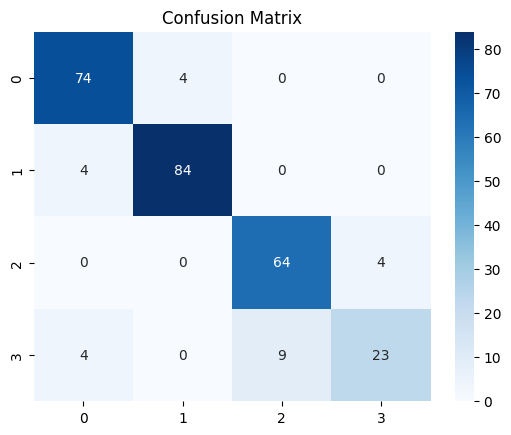

In [10]:
def evaluate(model):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x)
            _, preds = torch.max(out, 1)
            y_true.extend(y.numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

evaluate(model)